### Sekcja generowania danych historycznych

In [17]:
import random as rnd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import math

def errorify(value):
    error_factors = [0.01,0.1,10,100]
    error_value = value * rnd.choice(error_factors)
    return error_value

def error_price(price):
    return errorify(price)

def error_quantity(quantity):
    return errorify(quantity)

def gen_product(orders_no, price_init, price_end, order_qunat_rng, error_prob, bend):
    price_curr = price_init
    price_diff = (price_end - price_init)
    price_delta = price_diff/orders_no
    product_orders = []
    for _ in range(orders_no):
        price = round(price_curr + (rnd.uniform(-0.2,0.2) * price_diff), 2)
        quantity = rnd.randrange(order_qunat_rng[0], order_qunat_rng[1])
        if rnd.random() < error_prob:
            if rnd.random() > 0.5:
                price = error_price(price)
            else:
                quantity = error_quantity(quantity)
        product_orders.append((price, quantity))
        price_curr += price_delta

    return product_orders

Przykładowe dane na podstawie treści zadania

[(97.01, 43), (97.83, 41), (96.23, 36), (101.03, 40), (97.9, 4.5), (1.0386, 40), (105.14, 35), (104.54, 34), (100.49, 43), (99.1, 39), (1.0579, 41), (10635.0, 49), (103.16, 37), (101.7, 43), (107.31, 37), (109.94, 46), (10.568000000000001, 37), (103.45, 4500), (106.92, 37), (106.2, 50), (104.82, 0.45), (10.780000000000001, 49), (105.29, 45), (106.01, 41), (114.08, 32), (1.0891, 36), (111.15, 50), (115.12, 39), (108.68, 41), (109.28, 0.48), (109.03, 40), (114.65, 36), (11109.0, 30), (109.91, 3.6), (110.41, 39), (112.55, 47), (116.09, 37), (118.29, 36), (118.58, 37), (116.67, 30), (113.09, 45), (117.15, 32), (1215.4, 42), (113.32, 35), (114.57, 4.4), (118.71, 30), (118.53, 44), (12.314, 42), (120.91, 50), (121.86, 33), (117.75, 43), (116.97, 48), (121.89, 33), (119.74, 0.37), (117.39, 42), (121.27, 50), (125.81, 43), (122.54, 41), (120.4, 46), (12.274000000000001, 45)]


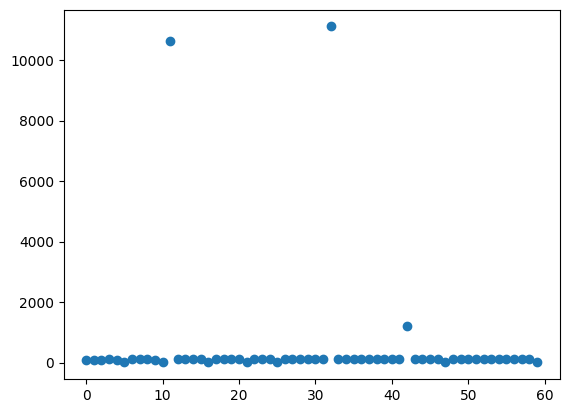

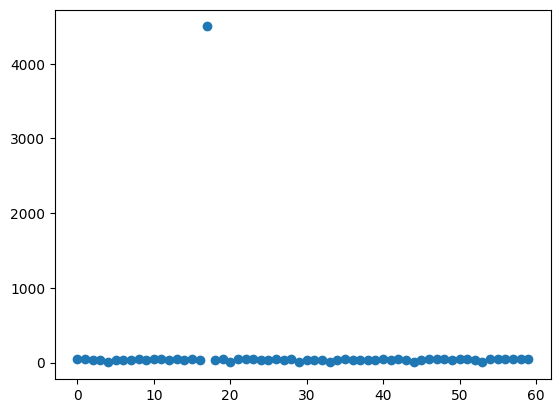

<Figure size 640x480 with 0 Axes>

In [18]:
product_sales = gen_product(60, 100, 124, (30,51), 0.2, 1)
print(product_sales)
x = [x for x in range(60)]
y_price = [x[0] for x in product_sales]
y_quantity = [x[1] for x in product_sales]
plt.scatter(x, y_price)
plt.show()
plt.clf()
plt.scatter(x, y_quantity)
plt.show()
plt.clf()

### Zastosowanie regresji liniowej

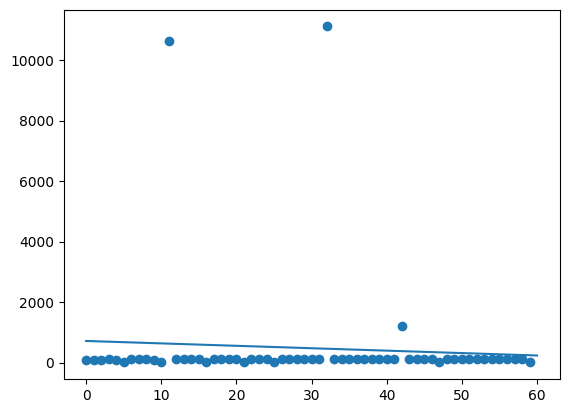

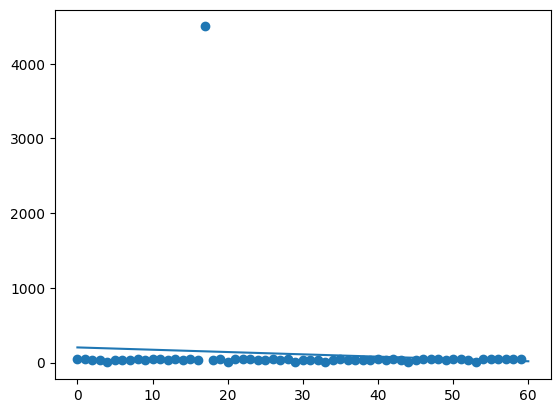

<Figure size 640x480 with 0 Axes>

In [19]:
def get_coeffs(x, y):
    x_np = np.array(x). reshape((-1,1))
    y_price = np.array(y)
    model_price = LinearRegression().fit(x_np, y_price)

    return (model_price.coef_[0], model_price.intercept_)

def print_with_approx(x, y, coeffs):
    n = len(x)
    plt.scatter(x, y)
    plt.plot([0,n], [coeffs[1], n * coeffs[0] + coeffs[1]])
    plt.show()
    plt.clf()

coeffs_p = get_coeffs(x, y_price)
coeffs_q = get_coeffs(x, y_quantity)
print_with_approx(x, y_price, coeffs_p)
print_with_approx(x, y_quantity, coeffs_q)

Remove outliers

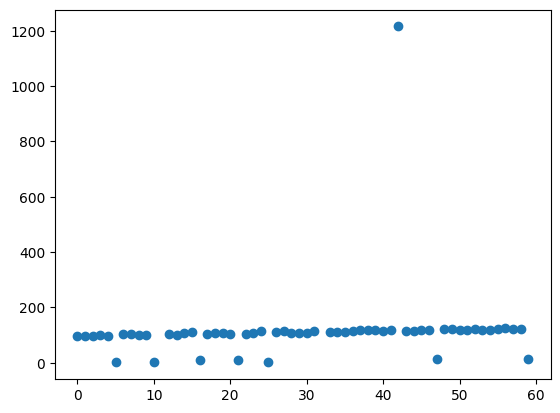

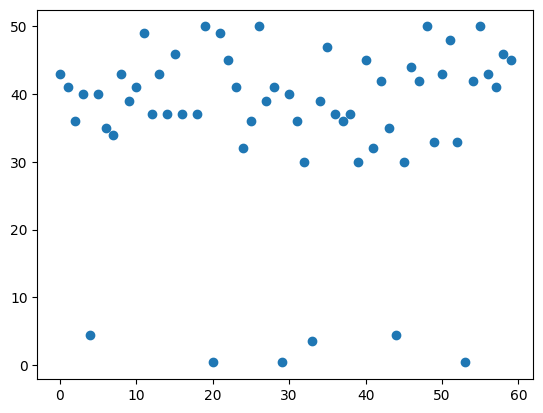

<Figure size 640x480 with 0 Axes>

In [20]:
def remove_outliers(x, y, coeffs):
    n = len(x)
    if n <= 2:
        return (x, y, 0)
    y_exp = [(x * coeffs[0] + coeffs[1]) for x in x]

    SSE = 0

    for i in range(n):
        SSE += (y[i] - y_exp[i])**2

    s = math.sqrt(SSE/(n-2))
    x_good = []
    y_good = []
    outlier_count = 0

    for i in range(n):
        if abs(y[i] - y_exp[i]) < abs(2 * s):
            x_good.append(i)
            y_good.append(y[i])
        else:
            outlier_count += 1

    return (x_good, y_good, outlier_count)

x_price, y_price, outlier_count_p = remove_outliers(x, y_price, coeffs_p)
x_quantity, y_quantity, outlier_count_q = remove_outliers(x, y_quantity, coeffs_q)

plt.scatter(x_price, y_price)
plt.show()
plt.clf()
plt.scatter(x_quantity, y_quantity)
plt.show()
plt.clf()

Repeat Linear regression and elemination to get good lines

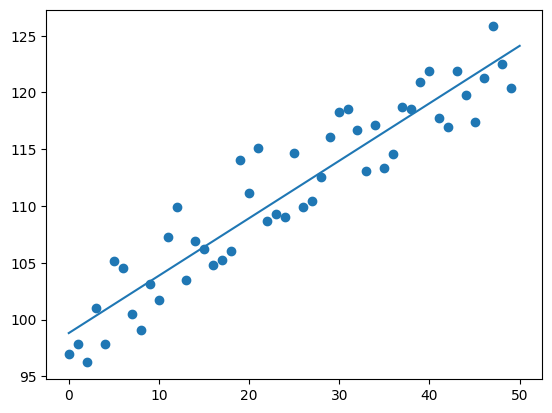

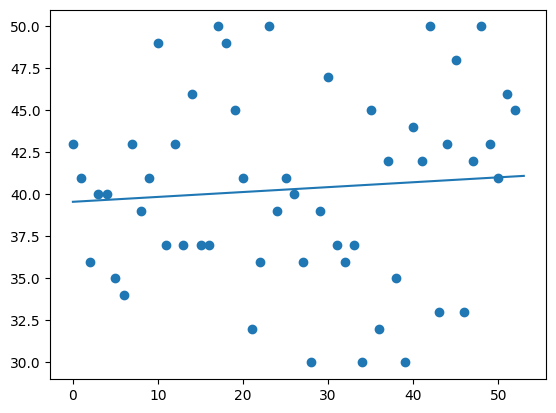

<Figure size 640x480 with 0 Axes>

In [21]:
coeffs_p = get_coeffs(x_price, y_price)
while outlier_count_p > 0:
    x_price, y_price, outlier_count_p = remove_outliers(x_price, y_price, coeffs_p)
    coeffs_p = get_coeffs(x_price, y_price)

coeffs_q = get_coeffs(x_quantity, y_quantity)
while outlier_count_q > 0:
    x_quantity, y_quantity, outlier_count_q = remove_outliers(x_quantity, y_quantity, coeffs_q)
    coeffs_q = get_coeffs(x_quantity, y_quantity)

print_with_approx(x_price, y_price, coeffs_p)
print_with_approx(x_quantity, y_quantity, coeffs_q)

In [23]:
def get_diffs(x,y,coeffs):
    n = len(x)
    y_exp = [(x * coeffs[0] + coeffs[1]) for x in x]
    return [y[i] - y_exp[i] for i in range(n)]

def get_threshold(diffs, alpha):
    n = len(diffs)
    diffs_abs = [abs(x) for x in diffs]
    diffs_abs.sort()
    return diffs_abs[math.ceil(n * alpha)]

def get_threshold_markov(diffs, alpha):
    n = len(diffs)
    diffs_abs = [abs(x) for x in diffs]
    EX = sum(diffs_abs)/n
    return EX/(1-alpha)

def get_threshold_chebyshev(diffs, alpha):
    n = len(diffs)
    VarX = sum([x**2 for x in diffs])/n
    return math.sqrt(VarX/(1-alpha))

diffs = get_diffs(x_price, y_price, coeffs_p)

print(get_threshold(diffs, 0.9))
print(get_threshold_markov(diffs, 0.9))
print(get_threshold_chebyshev(diffs, 0.9))
    

4.187248499399757
23.24119721488595
8.444246449925707
